In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader.data as web
import pandas_datareader as pdr
from database.adatabase import ADatabase
from processor.processor import Processor as p
from datetime import datetime
from tqdm import tqdm
import warnings
warnings.simplefilter(action="ignore")

In [53]:
market = ADatabase("market")

In [54]:
fama_french_factors = web.DataReader('F-F_Research_Data_Factors_daily',"famafrench")[0]

In [55]:
fff = fama_french_factors.reset_index().rename(columns={"Date":"date"})
fff["date"] = [str(x) for x in fff["date"]]
fff = p.column_date_processing(fff)
fff

,date,mkt-rf,smb,hml,rf
0,2019-10-28,0.62,0.27,-0.24,0.007
1,2019-10-29,-0.13,0.30,0.50,0.007
2,2019-10-30,0.27,-0.37,-1.16,0.007
3,2019-10-31,-0.38,-0.26,-0.43,0.007
4,2019-11-01,1.08,0.48,0.84,0.006
...,...,...,...,...,...
1214,2024-08-26,-0.34,0.10,0.16,0.022
1215,2024-08-27,0.06,-0.86,0.02,0.022
1216,2024-08-28,-0.67,-0.55,1.14,0.022
1217,2024-08-29,0.08,0.38,0.28,0.022


In [56]:
factors = [x for x in fff.columns if x != "date"]

In [57]:
market.connect()
sp500 = market.retrieve("sp500")
market.disconnect()

In [58]:
start = datetime(2020,1,1)
end = datetime.now()

In [79]:
market.connect()
sim = []
for ticker in tqdm(sp500["ticker"]):
    try:
        prices = p.column_date_processing(market.query("prices",{"ticker":ticker}))
        prices = prices.merge(fff,on="date",how="left")
        prices["year"] = [x.year for x in prices["date"]]
        prices["quarter"] = [x.quarter for x in prices["date"]]
        prices["sell_price"] = prices["adjclose"]
        prices["expected_return"] = prices["adjclose"].pct_change(60)
        prices["risk"] = prices["adjclose"].rolling(100).std()
        for factor in factors:
            prices["factor_return"] = prices[factor].rolling(100).mean()
            prices["beta"] = prices["expected_return"].rolling(100).cov(prices["factor_return"])
            prices["var"] = prices["factor_return"].rolling(100).var()
            prices[f"{factor}_excess_return"] = prices["mkt-rf"] + prices["beta"] * (prices["expected_return"] - prices["mkt-rf"])
        prices["excess_return"] = [mean([row[1][f"{factor}_excess_return"] for x in factors])/len(factors) for row in prices.iterrows()]
        prices = prices.groupby(["ticker","year","quarter"]).agg({"risk":"mean","excess_return":"first","adjclose":"first","sell_price":"last"}).reset_index()
        sim.append(prices)
    except:
        continue

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 503/503 [01:34<00:00,  5.31it/s]


In [80]:
simulation = pd.concat(sim)
simulation

,ticker,year,quarter,risk,excess_return,adjclose,sell_price
0,MMM,2010,4,NaN,NaN,48.760232,47.326744
1,MMM,2011,1,1.596426,NaN,47.595459,51.580650
2,MMM,2011,2,1.614734,NaN,51.376534,52.631752
3,MMM,2011,3,2.393901,NaN,53.641660,40.106607
4,MMM,2011,4,3.385821,NaN,39.626155,45.982407
...,...,...,...,...,...,...,...
52,ZBH,2023,4,11.222310,-0.139994,110.507757,120.942174
53,ZBH,2024,1,6.999407,-0.699982,120.634105,131.395533
54,ZBH,2024,2,4.447893,-0.269997,129.175409,108.289246
55,ZBH,2024,3,6.598244,0.219996,105.724947,107.950000


In [81]:
positions = 10
simulation = simulation.sort_values(["year","quarter","excess_return"]).dropna()
trades = simulation.groupby(["year","quarter"]).nth([i for i in range(positions)]).reset_index()

In [82]:
trades["return"] = (trades["sell_price"] - trades["adjclose"]) / trades["adjclose"]

In [83]:
trades.sort_values("return",ascending=False).head(20)

,index,ticker,year,quarter,risk,excess_return,adjclose,sell_price,return
14,40,TRGP,2020,4,2.513107,0.789714,12.547478,24.526505,0.954696
17,32,FANG,2020,4,5.246398,0.789756,24.053912,40.465954,0.682302
7,39,BLDR,2020,3,4.506543,-0.831155,19.730000,32.620000,0.653320
25,41,MRO,2021,1,1.687343,-1.410048,6.457871,10.129828,0.568602
21,41,OXY,2021,1,4.921620,-1.410063,16.880443,25.760129,0.526034
28,33,FANG,2021,1,11.108745,-1.410045,40.917433,61.773197,0.509704
12,8,MRNA,2020,4,14.097758,0.789407,70.030000,104.470000,0.491789
100,49,FSLR,2023,1,17.655039,-0.480458,145.940000,217.500000,0.490338
162,55,BLDR,2024,3,19.870586,0.219986,133.990000,193.860000,0.446824
94,48,AXON,2022,4,20.242439,2.549150,115.970000,165.930000,0.430801


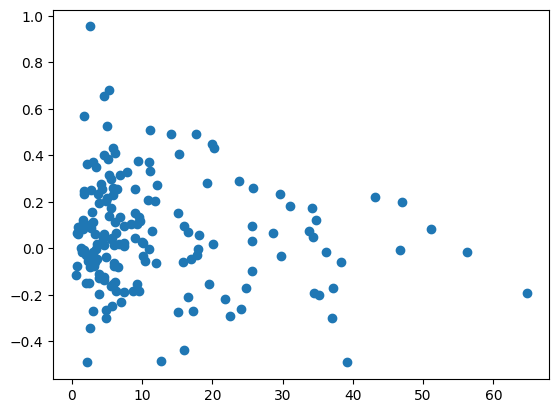

In [84]:
plt.scatter(trades["risk"],trades["return"])
plt.show()

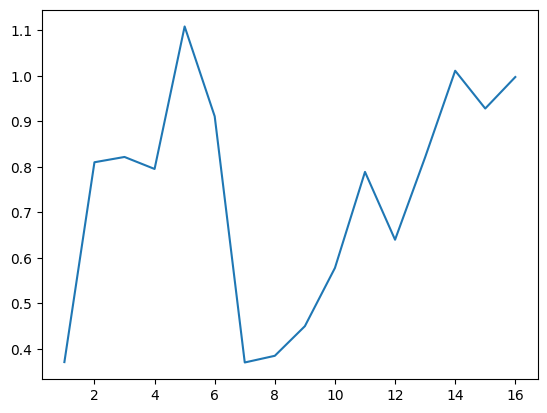

In [85]:
portfolio = trades.groupby(["year","quarter"]).agg({"return":"mean"}).reset_index()[1:]
portfolio["return"] = portfolio["return"] + 1
portfolio["cum_return"] = portfolio["return"].cumprod() -1
plt.plot(portfolio["cum_return"])
plt.show()